# Clustering of drawn components in galaxy builder

### Problem:

*Given a set of ellipses and rotated rectangles (in zooniverse coordinates), how do we recover one aggregate shape for each task?*

First, say the jupyter magic words 🧙‍

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import the plethora of useful modules we'll need (including some we probably don't)

In [24]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
from pprint import pprint
from shapely.affinity import scale, translate
from descartes import PolygonPatch
from sklearn.cluster import DBSCAN
from panoptes_aggregation.reducers.shape_metric import avg_angle
import lib.galaxy_utilities as gu
import wrangle_classifications as wc
from main import DISK_EPS, BULGE_EPS, BAR_EPS
from main import DISK_MIN_SAMPLES, BULGE_MIN_SAMPLES, BAR_MIN_SAMPLES

In [3]:
font = {'family' : 'DejaVu Sans',
        'size'   : 16}

matplotlib.rc('font', **font)

Which subject should we work on? (parametrised to allow batch running at a later date)

In [4]:
subject_id = 20902040

Implement a temporary way of reading in data till the zooniverse CSV export is fixed:

In [5]:
with open('tmp_cls_dump.json') as f:
    classifications = json.load(f)
classifications_for_subject = [
    c for c in classifications
    if c['links']['subjects'][0] == str(subject_id)
]
print('Found {} classifications for subject_id {}'.format(
    len(classifications_for_subject),
    subject_id,
))
annotations_for_subject = [i['annotations'] for i in classifications_for_subject]

Found 32 classifications for subject_id 20902040


Grab the galaxy data (and classification data) for this galaxy

In [6]:
print('Getting galaxy data')
gal, angle = gu.get_galaxy_and_angle(subject_id)
url = gu.getUrl(subject_id)
pic_array, deprojected_image = gu.get_image(gal, subject_id, angle)
# classifications = gu.classifications
# classifications_for_subject = classifications['subject_ids'] == subject_id
# annotations_for_subject = [
#     eval(foo) for foo in
#     classifications_for_subject
# ]

Getting galaxy data


/Users/tlingard/PhD/galaxy-builder/data-aggregation/component-clustering/lib/galaxy_utilities.py:77: UserWarning: Using montaged image
  __import__('warnings').warn('Using montaged image')


Define some useful goodies for plotting later (to transform from image coordinates to arcseconds from centre of galaxy)

In [7]:
pix_size = pic_array.shape[0] / (gal['PETRO_THETA'].iloc[0] * 4)

def transform_patch(p):
    return scale(
        translate(p, xoff=-pic_array.shape[0]/2, yoff=-pic_array.shape[1]/2),
        xfact=1/pix_size,
        yfact=1/pix_size,
        origin=(0, 0),
    )
imshow_kwargs = {
    'cmap': 'gray_r', 'origin': 'lower',
    'extent': (
        -pic_array.shape[0]/2 / pix_size,
        pic_array.shape[0]/2 / pix_size,
        -pic_array.shape[1]/2 / pix_size,
        pic_array.shape[1]/2 / pix_size
    ),
}

Iterate through the annotations and grab the classifications for disks, bulges and bars:

In [8]:
disks = [a[0] for a in annotations_for_subject if len(a) == 4]
bulges = [a[1] for a in annotations_for_subject if len(a) == 4]
bars = [a[2] for a in annotations_for_subject if len(a) == 4]

Filter those down to only the annotations where a volunteer has drawn something

In [9]:
drawn_disks = [i for i in disks if len(i['value'][0]['value']) > 0]
drawn_bulges = [i for i in bulges if len(i['value'][0]['value']) > 0]
drawn_bars = [i for i in bars if len(i['value'][0]['value']) > 0]

print('Received:\n\t{} disks\n\t{} bulges\n\t{} bars'.format(
    len(drawn_disks),
    len(drawn_bulges),
    len(drawn_bars)
))

Received:
	28 disks
	24 bulges
	17 bars


Make use of some handy functions in `wrangle_classifications` to convert these annotations to [`Shapely`](https://shapely.readthedocs.io/en/stable/) geometries

In [10]:
disk_geoms = np.array([
    wc.ellipse_geom_from_zoo(d['value'][0]['value'][0])
    for d in drawn_disks
])
bulge_geoms = np.array([
    wc.ellipse_geom_from_zoo(b['value'][0]['value'][0])
    for b in drawn_bulges
])
bar_geoms = np.array([
    wc.bar_geom_from_zoo(b['value'][0]['value'][0])
    for b in drawn_bars
])

Let's have a look at what we're working with:

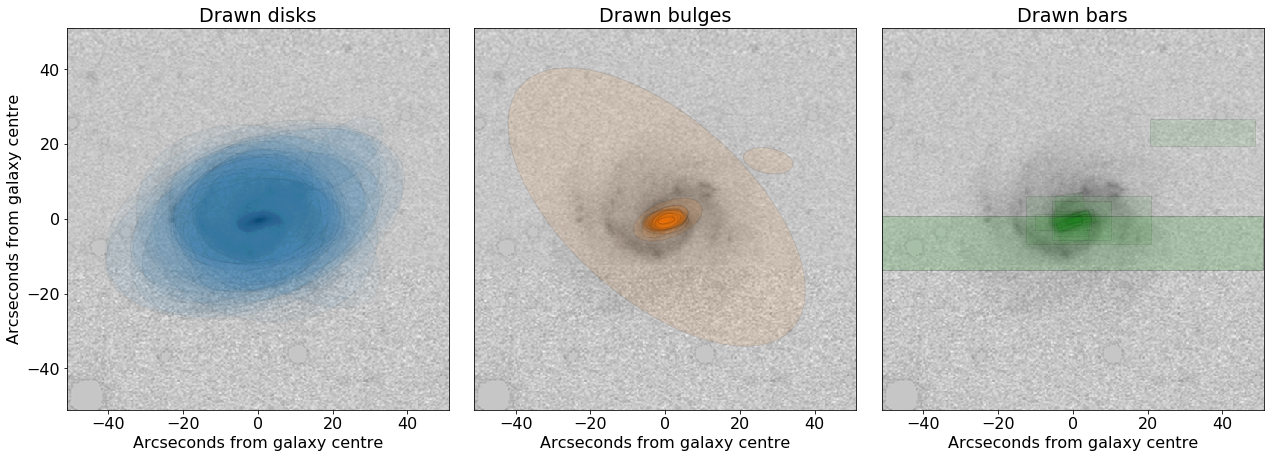

In [11]:
fig = plt.figure(figsize=(18, 6))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.subplot(131)
plt.imshow(pic_array, **imshow_kwargs)

for patch in disk_geoms:
    p = PolygonPatch(transform_patch(patch), fc='C0', ec='k', alpha=0.05, zorder=2)
    plt.gca().add_patch(p)
plt.title('Drawn disks')
plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre')

plt.subplot(132)
plt.imshow(pic_array, **imshow_kwargs)
for patch in bulge_geoms:
    p = PolygonPatch(transform_patch(patch), fc='C1', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
plt.title('Drawn bulges')
plt.xlabel('Arcseconds from galaxy centre')
plt.yticks([])

plt.subplot(133)
plt.imshow(pic_array, **imshow_kwargs)
for patch in bar_geoms:
    p = PolygonPatch(transform_patch(patch), fc='C2', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
plt.title('Drawn bars')
plt.xlabel('Arcseconds from galaxy centre')
plt.yticks([])

plt.tight_layout()
plt.savefig('method-paper-plots/drawn_shapes.pdf', bbox_inches='tight')
plt.savefig('method-paper-plots/drawn_shapes.png', bbox_inches='tight')

# Clustering components:


Chosen metric is based on the *Jaccard similarity score*:

$$S = \frac{\text{intersection area}}{\text{union area}}$$

Instead we use the *Jaccard distance*

$$S = 1 - \frac{\text{intersection area}}{\text{union area}}$$

Calculate a pre-computed distance matrix for each component (not slow as we're using well-optimized `shapely` methods)

In [12]:
disk_distances = wc.gen_jaccard_distances(disk_geoms)
bulge_distances = wc.gen_jaccard_distances(bulge_geoms)
bar_distances = wc.gen_jaccard_distances(bar_geoms)

Define our clusterers (we'll use DBSCAN, though HDBSCAN might be a better alternative). Using one each as it allows tuning of the parameters for each component.

In [13]:
clf_disk = DBSCAN(eps=DISK_EPS, min_samples=DISK_MIN_SAMPLES,
                  metric='precomputed')
clf_disk.fit(disk_distances)
disk_labels = clf_disk.labels_

clf_bulge = DBSCAN(eps=BULGE_EPS, min_samples=BULGE_MIN_SAMPLES,
                   metric='precomputed')
clf_bulge.fit(bulge_distances)
bulge_labels = clf_bulge.labels_

clf_bar = DBSCAN(eps=BAR_EPS, min_samples=BAR_MIN_SAMPLES,
                 metric='precomputed')
clf_bar.fit(bar_distances)
bar_labels = clf_bar.labels_

Our resulting clusters look like this: (empty sub-plot means no cluster)

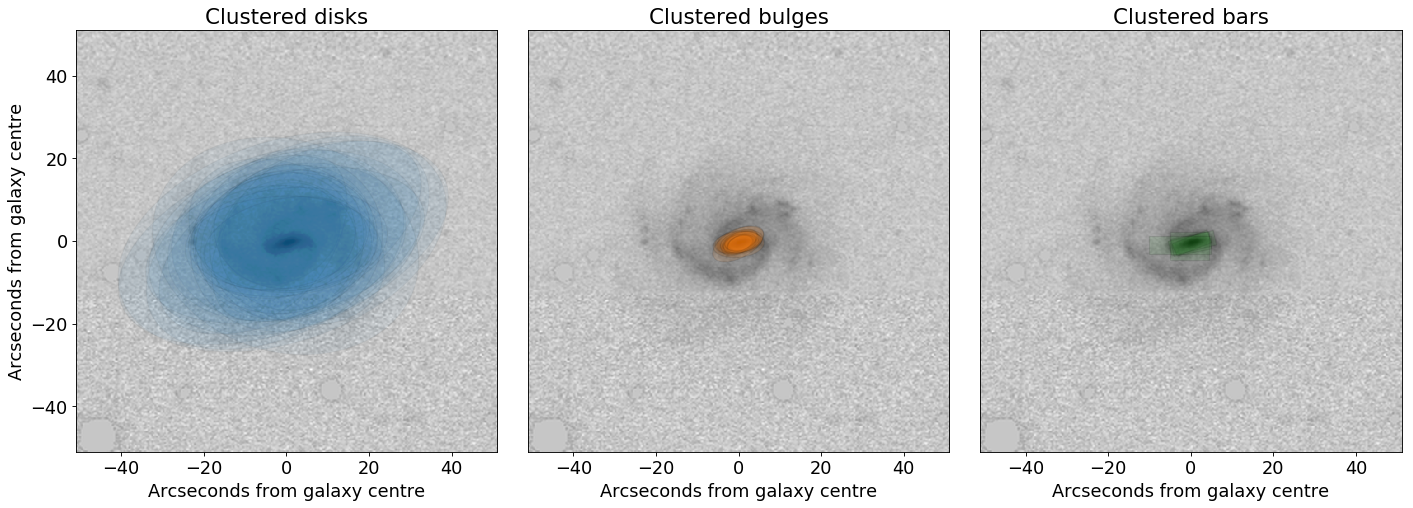

In [14]:
fig = plt.figure(1, figsize=(18, 6), dpi=80)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.subplot(131)
plt.imshow(pic_array, **imshow_kwargs)
for disk in disk_geoms[disk_labels == 0]:
    p = PolygonPatch(transform_patch(disk), fc='C0', ec='k', alpha=0.05, zorder=2)
    plt.gca().add_patch(p)
plt.title('Clustered disks')
plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre')

plt.subplot(132)
plt.imshow(pic_array, **imshow_kwargs)
for bulge in bulge_geoms[bulge_labels == 0]:
    p = PolygonPatch(transform_patch(bulge), fc='C1', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
plt.yticks([])
plt.title('Clustered bulges')
plt.xlabel('Arcseconds from galaxy centre')

plt.subplot(133)
plt.imshow(pic_array, **imshow_kwargs)
for bar in bar_geoms[bar_labels == 0]:
    p = PolygonPatch(transform_patch(bar), fc='C2', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
plt.yticks([])
plt.title('Clustered bars')
plt.xlabel('Arcseconds from galaxy centre')

plt.tight_layout()
plt.savefig('method-paper-plots/clustered_shapes.pdf', bbox_inches='tight')
plt.savefig('method-paper-plots/clustered_shapes.png', bbox_inches='tight')

Let's grab the original annotation data for these clustered shapes

In [15]:
clustered_disks = [d['value'][0]['value'][0] for d in np.array(drawn_disks)[disk_labels == 0]]
clustered_bulges = [b['value'][0]['value'][0] for b in np.array(drawn_bulges)[bulge_labels == 0]]
clustered_bars = [b['value'][0]['value'][0] for b in np.array(drawn_bars)[bar_labels == 0]]

## Mean component calculation

We'll calculate our aggregate component by calculating:
- the mean of the center points of each shape
- the mean of widths and heights of each shape
- the circular mean of the angle of each shape (performed using the zooniverse's `panoptes-aggregation` package)

{'angle': 165.827,
 'rx': 132.77455615180224,
 'ry': 86.6625335530112,
 'x': 254.53399724545687,
 'y': 256.25090557595956}


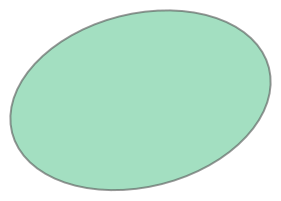

In [16]:
mean_disk = {}
mean_disk['x'] = np.mean([i['x'] for i in clustered_disks])
mean_disk['y'] = np.mean([i['y'] for i in clustered_disks])
mean_disk['rx'] = np.mean([max(i['rx'], i['ry']) for i in clustered_disks])
mean_disk['ry'] = np.mean([min(i['rx'], i['ry']) for i in clustered_disks])
disk_angles = [
    i['angle'] if i['rx'] > i['ry'] else (i['angle'] + 90)
    for i in clustered_disks
]
mean_disk['angle'] = avg_angle(disk_angles, factor=2)

mean_disk_geom = wc.ellipse_geom_from_zoo(mean_disk)
pprint(mean_disk)
mean_disk_geom

{'angle': 163.673,
 'rx': 23.112571104358633,
 'ry': 11.857328187297503,
 'x': 257.90004577636716,
 'y': 253.97162068684895}


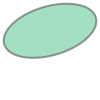

In [17]:
mean_bulge = {}
mean_bulge['x'] = np.mean([i['x'] for i in clustered_bulges])
mean_bulge['y'] = np.mean([i['y'] for i in clustered_bulges])
mean_bulge['rx'] = np.mean([max(i['rx'], i['ry']) for i in clustered_bulges])
mean_bulge['ry'] = np.mean([min(i['rx'], i['ry']) for i in clustered_bulges])
bulge_angles = [
    i['angle'] if i['rx'] > i['ry'] else (i['angle'] + 90)
    for i in clustered_bulges
]

mean_bulge['angle'] = avg_angle(bulge_angles, factor=2)

mean_bulge_geom = wc.ellipse_geom_from_zoo(mean_bulge)
pprint(mean_bulge)
mean_bulge_geom

{'angle': 9.377,
 'height': 22.186395937844946,
 'width': 53.89786754363083,
 'x': 226.7693294728135,
 'y': 240.8729839768783}


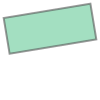

In [18]:
center_xs = [i['x'] + i['width']/2 for i in clustered_bars]
center_ys = [i['y'] + i['height']/2 for i in clustered_bars]
mean_center = (np.mean(center_xs), np.mean(center_ys))

mean_bar = {}
mean_bar['width'] = np.mean([max(i['width'], i['height']) for i in clustered_bars])
mean_bar['height'] = np.mean([min(i['width'], i['height']) for i in clustered_bars])
mean_bar['x'] = mean_center[0] - mean_bar['width'] / 2
mean_bar['y'] = mean_center[1] - mean_bar['height'] / 2
bar_angles = [
    i['angle'] if i['width'] > i['height'] else (i['angle'] + 90)
    for i in clustered_bars
]
mean_bar['angle'] = avg_angle(bar_angles, factor=2)

mean_bar_geom = wc.bar_geom_from_zoo(mean_bar)
pprint(mean_bar)
mean_bar_geom

If there's an error, it's because there was no cluster to aggregate!

Let's have a look at our resulting shapes relative to their clusters!

In [19]:
bulge_crop = 20
bar_crop = 20

In [20]:
print('Defining patches...')
mean_disk_patch = PolygonPatch(transform_patch(mean_disk_geom), fc='C1', ec='k', alpha=0.4, zorder=3)
try:
    mean_bulge_patch = PolygonPatch(transform_patch(mean_bulge_geom), fc='C2', ec='k', alpha=0.5, zorder=3)
except NameError:
    pass
try:
    mean_bar_patch = PolygonPatch(transform_patch(mean_bar_geom), fc='C3', ec='k', alpha=0.5, zorder=3)
except NameError:
    pass

Defining patches...


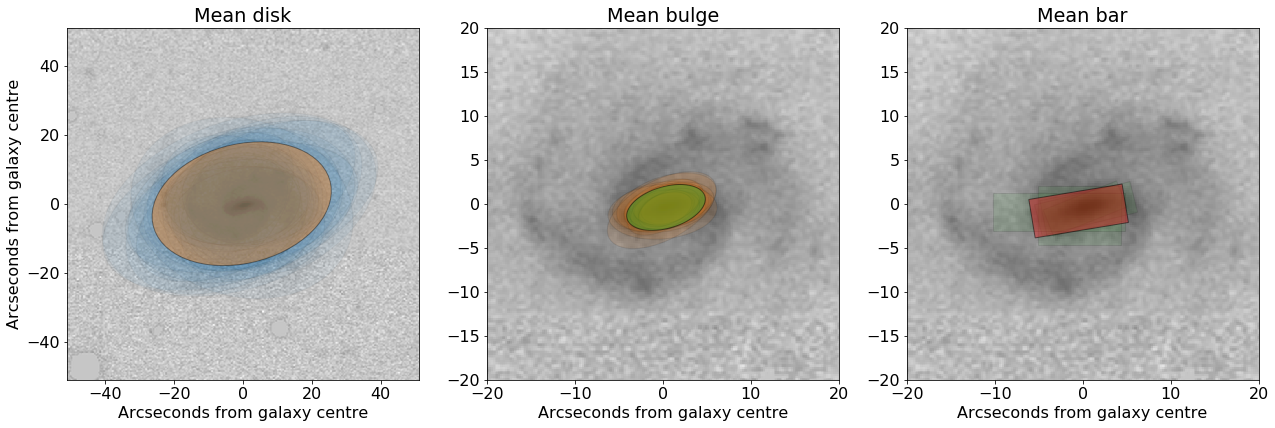

In [21]:
fig = plt.figure(1, figsize=(18, 6))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

plt.subplot(131)
plt.imshow(pic_array, **imshow_kwargs)
for disk in disk_geoms[disk_labels == 0]:
    p = PolygonPatch(transform_patch(disk), fc='C0', ec='k', alpha=0.05, zorder=2)
    plt.gca().add_patch(p)
plt.gca().add_patch(mean_disk_patch)
plt.title('Mean disk')
plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre')

plt.subplot(132)
plt.imshow(pic_array, **imshow_kwargs)
for bulge in bulge_geoms[bulge_labels == 0]:
    p = PolygonPatch(transform_patch(bulge), fc='C1', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
try:
    plt.gca().add_patch(mean_bulge_patch)
except NameError:
    pass
plt.title('Mean bulge')
plt.xlabel('Arcseconds from galaxy centre')
plt.xlim(-bulge_crop, bulge_crop);
plt.ylim(-bulge_crop, bulge_crop)

plt.subplot(133)
plt.imshow(pic_array, **imshow_kwargs)
for bar in bar_geoms[bar_labels == 0]:
    p = PolygonPatch(transform_patch(bar), fc='C2', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
try:
    plt.gca().add_patch(mean_bar_patch)
except NameError:
    pass
plt.title('Mean bar')
plt.xlabel('Arcseconds from galaxy centre')
plt.xlim(-bar_crop, bar_crop)
plt.ylim(-bar_crop, bar_crop)

plt.tight_layout()
plt.savefig('method-paper-plots/mean_shapes.pdf', bbox_inches='tight')
plt.savefig('method-paper-plots/mean_shapes.png', bbox_inches='tight')

And finally, let's see our resulting galaxy model

In [22]:
print('Defining patches...')
mean_disk_patch = PolygonPatch(transform_patch(mean_disk_geom), fc='C0', ec='k', alpha=0.2, zorder=3)
try:
    mean_bulge_patch = PolygonPatch(transform_patch(mean_bulge_geom), fc='C1', ec='k', alpha=0.5, zorder=3)
except NameError:
    pass
try:
    mean_bar_patch = PolygonPatch(transform_patch(mean_bar_geom), fc='C2', ec='k', alpha=0.5, zorder=3)
except NameError:
    pass

Defining patches...


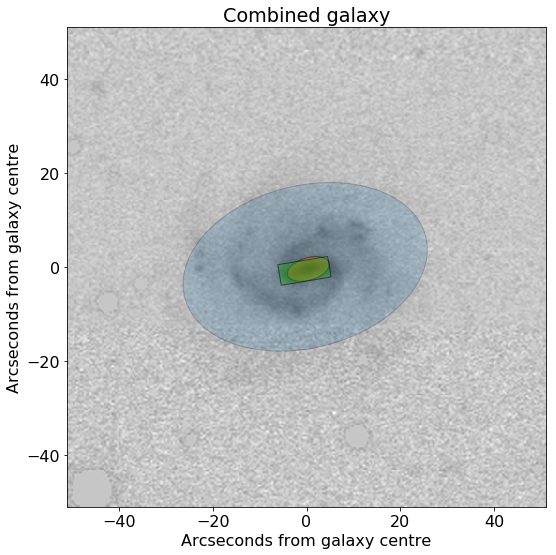

In [23]:
plt.figure(figsize=(8,8))
plt.title('Combined galaxy')
plt.imshow(pic_array, **imshow_kwargs)
try:
    plt.gca().add_patch(mean_disk_patch)
except NameError:
    pass
try:
    plt.gca().add_patch(mean_bulge_patch)
except NameError:
    pass
try:
    plt.gca().add_patch(mean_bar_patch)
except NameError:
    pass

plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre')

plt.tight_layout()
plt.savefig('method-paper-plots/clustered_shapes.pdf', bbox_inches='tight')
plt.savefig('method-paper-plots/clustered_shapes.png', bbox_inches='tight')

And there we have it! A complex photometric model (sort of) fit to SDSS r-band data, performed using citizen science